In [8]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

# 시각화 함수

In [9]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 학습 데이터 경로 정의

In [10]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

# 랜덤 시드 고정

In [11]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 파일 로드

In [12]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [13]:
# Show length
print(len(index_inputs),  len(index_outputs), len(index_targets))

20 20 20


## 모델 만들기에 필요한 값 선언

In [15]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol'] # 시작 토큰
end_index = prepro_configs['end_symbol'] # 종료 토큰
vocab_size = prepro_configs['vocab_size']

# 모델
## 인코더

In [28]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                  self.embedding_dim)
        
        self.gru = tf.keras.layers.GRU(self.enc_units, # GRU의 output dim
                                      return_sequences=True, # 각 시퀀스마다 출력을 반환할지 여부
                                      return_state=True, # 마지막 상태 값 반환 여부
                                      recurrent_initializer='glorot_uniform') # Xavier 초기화 (이전 노드와 다음 노드 개수에 의존함)
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    # 배치 크기를 받아 RNN의 초기에 사용될 크기의 은닉상태를 만듬
    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))
        
        
        

## 어텐션
- 기존 시퀀스투시퀀스 모델의 문제점
    - 고정길이에 담으므로 정보의 손실이 있다.
    - RNN 특유의 문제인 장기 의존성 문제
- 기존 시퀀스투시퀀스는 인코더의 고정된 문맥 벡터가 디코더로 전달됨
- 어텐션티 추가된 방법은 은닉 상태의 값을 어텐션을 통해 계산하고, 디코더의 각 시퀀스 스텝마다 계산된 어텐션을 입력으로 넣음
    - 즉, 어텐션도 함께 학습을 진행하게 되며, 학습을 통해 디코더의 각 시퀀스 스텝마다 어텐션의 가중치는 다르게 적용됨

In [46]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) # units: 출력 크기
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    

    def call(self, query, values): 
        # query: 인코더 RNN의 은닉 상태 값, values: 인코더 RNN의 결과값
        
        # query를 W2에 행렬곱을 할 수 있는 형태를 만듬
        hidden_with_time_axis = tf.expand_dims(query, 1) 
        
        # 최종적으로 1차원 벡터값이 나옴 (훈련중 가중치 W1, W2, V는 학습됨)
        score = self.V(
            tf.nn.tanh(self.W1(values) + 
                                  self.W2(hidden_with_time_axis)))
        
        # 모델이 중요하다고 판단하는 값은 1에 가까워지고,
        # 영향도가 떨어질수록 0에 가까워짐
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # 어텐션 가중치와 values(RNN의 결과값) 행렬곱
        # => 1에 가까운 값에 위치한 value의 값은 커지고,
        #    0에 가까운 값에 위치한 value의 값은 작아짐
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights
        
        
        

## 디코더

In [47]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim  
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        # 문맥 벡터와 임베딩 벡터를 결합
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
        # 디코더의 RNN을 통해 결과값(output)을 얻게 됨
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
            
        # output을 FC 레이어에 통과시켜서 사전 크기의 벡터 x를 만든다.
        x = self.fc(output)
        
        return x, state, attention_weights
    

In [48]:
# 아담 최적화
optimizer = tf.keras.optimizers.Adam()

# 크로스 엔트로피 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# 정확도 측정
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')


def loss(real, pred):
    # <PAD>는 0, 값이 0이 아닌건 1로 변환
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # 0인건 <PAD>는 손실에서 빼기 위함
    
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)



## 시퀀스 투 스퀀스 모델 (메인 클래스)

In [74]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx=2):
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)
    
    def call(self, x):
        inp, tar = x # question, answer
        
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        # 디코더는 시퀀스의 최대길이만큼 반복하면서 디코더의 출력값을 만들어낸다.
        predict_tokens = list() # 디코더의 출력값
        for t in range(0, tar.shape[1]):
            dec_input =  tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) 
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0]) # 시퀀스마다 나온 결과값
    
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
        
        # 이건 손실, 정확도를 계산하는 용도로 쓰임
        return tf.stack(predict_tokens, axis=1) 
    
    def inference(self, x):
        inp = x
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([char2idx[std_index]], 1)
        predict_tokens = list()
        
        for t in range(0, MAX_SEQUENCES):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])
            
            if predict_token == self.end_token_idx:
                break
            
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)   
        
        return tf.stack(predict_tokens, axis=0).numpy()
        
    

In [75]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])
#model.run_eagerly = True

## 학습 진행

In [76]:
# 콜백 설정
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))
        
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)
# min_delta: 모델의 val_accuarcy가 0.0001 보다 적은경우 개선되지 않았다고 판단 

# 성능이 증가하지 않는다고, 그 순간 바로 멈추는 것은 효과적이지않을 수 있다. 
# patience 는 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의한다. 
# partience 는 다소 주관적인 기준이다. 사용한 데이터와 모델의 설계에 따라 최적의 값이 바뀔 수 있다. 






In [81]:

history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/30
9/9 [==============================] - 19s 2s/step - loss: 1.0304 - accuracy: 0.8600 - val_loss: 0.6138 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.86123
Epoch 2/30
9/9 [==============================] - 19s 2s/step - loss: 0.7426 - accuracy: 0.8598 - val_loss: 0.6481 - val_accuracy: 0.8599

Epoch 00002: val_accuracy did not improve from 0.86123
Epoch 3/30
9/9 [==============================] - 17s 2s/step - loss: 0.7255 - accuracy: 0.8599 - val_loss: 0.5752 - val_accuracy: 0.8598

Epoch 00003: val_accuracy did not improve from 0.86123
Epoch 4/30
9/9 [==============================] - 17s 2s/step - loss: 0.7001 - accuracy: 0.8598 - val_loss: 0.5904 - val_accuracy: 0.8598

Epoch 00004: val_accuracy did not improve from 0.86123
Epoch 5/30
9/9 [==============================] - 17s 2s/step - loss: 0.6728 - accuracy: 0.8598 - val_loss: 0.5618 - val_accuracy: 0.8597

Epoch 00005: val_accuracy did not improve from 0.86123
Epoch 6/30
9/9 [==============

## 결과 플롯


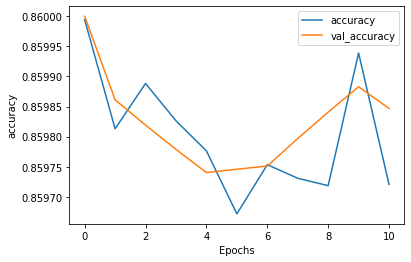

In [82]:
plot_graphs(history, 'accuracy')

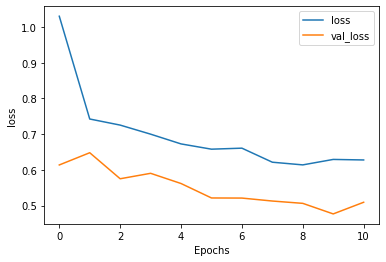

In [83]:
plot_graphs(history, 'loss')

### 결과 확인

In [84]:
SAVE_FILE_NM = "weights.h5"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [87]:
query = "남자친구 승진 선물로 뭐가 좋을까?"

test_index_inputs, _ = enc_processing([query], char2idx)    
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[]

